In [ ]:
!pip install tensorflow scikit-learn nltk pandas matplotlib seaborn


In [ ]:
import os
import re
import email

import numpy as np
import pandas as pd

from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/IA3Proiect/enron.zip" /content/
!unzip -q /content/enron.zip -d /content/enron

ham_dir = "/content/enron/enron/ham"
spam_dir = "/content/enron/enron/spam"

import os
print("Ham:", len(os.listdir(ham_dir)))
print("Spam:", len(os.listdir(spam_dir)))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/enron/enron/spam/4743.2005-06-25.GP.spam.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: Ham: 16544
Spam: 16081


In [ ]:
def numara_fisiere(director_list):
    """
    Afișează numărul total de fișiere găsite în fiecare director din lista 'director_list'
    """
    for d in director_list:
        foldere = 0
        for _, _, nume_fisiere in os.walk(d):
            foldere += len(nume_fisiere)
        if "ham" in d.lower():
            print('Sunt', foldere, 'fișiere în directorul Ham:', d)
        elif "spam" in d.lower():
            print('Sunt', foldere, 'fișiere în directorul Spam:', d)
        else:
            print('Nu se poate determina directorul:', d)

def creeaza_lista(dir_path):
    """
    Această funcție adaugă în lista_email fiecare fișier .txt din folderele spam și ham ale bazei de date Enron.
    Dacă e-mailul este multipart, părțile care îl compun vor fi adăugate separat în listă.
    """
    lista_email = []
    for dirpath, subdirectory, filenames in os.walk(dir_path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            try:
                with open(filepath, "r", encoding="latin-1") as f:
                    data = f.read()
            except Exception as e:
                # dacă apar erori de citire, le putem ignora sau loga
                print(f"Eroare la citirea fișierului {filepath}: {e}")
                continue

            b = email.message_from_string(data)
            if b.is_multipart():
                for payload in b.get_payload():
                    if payload.is_multipart():
                        for payload1 in payload.get_payload():
                            lista_email.append(str(payload1.get_payload()))
                    else:
                        lista_email.append(str(payload.get_payload()))
            else:
                lista_email.append(str(b.get_payload()))
    return lista_email

def organizator_date(lista_ham, lista_spam):
    """
    Convertește listele cu mesaje ham (legitime) și spam într-un DataFrame Pandas.
    eticheta: 0 - ham, 1 - spam
    """
    ham = pd.DataFrame({'email': lista_ham, 'eticheta': 0})
    spam = pd.DataFrame({'email': lista_spam, 'eticheta': 1})
    total_emailuri = pd.concat([ham, spam], ignore_index=True).sample(frac=1, random_state=42)
    return total_emailuri

def curatare_text(mesaj):
    """
    Curață textul e-mailurilor înainte de utilizarea într-un model de clasificare.
    """
    mesaj = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+', ' ', str(mesaj))
    mesaj = re.sub(r'<[^<]+?>', '', str(mesaj))
    mesaj = mesaj.translate(str.maketrans('', '', punctuation))
    mesaj = mesaj.lower()

    stop_words = set(stopwords.words('english'))
    is_short = len(mesaj) < 200

    if not is_short:
        mesaj = re.sub(r'\d+', '', str(mesaj))
        mesaj = re.sub(r'[^a-zA-Z]', ' ', str(mesaj))

    if not is_short:
        lem = WordNetLemmatizer()
        tokens = word_tokenize(mesaj)
        filtered_text = [lem.lemmatize(word) for word in tokens if word.lower() not in stop_words]
    else:
        tokens = word_tokenize(mesaj)
        filtered_text = [word for word in tokens if word.strip() != '']

    return ' '.join(filtered_text)

def preprocesare_date(df, nume_coloana):
    """
    Aplică funcția curatare_text pe coloana specificată din DataFrame.
    """
    df = df.copy()
    df[nume_coloana] = df[nume_coloana].astype(str).apply(curatare_text)
    return df



In [ ]:
# Verificăm numărul de fișiere
director = [ham_dir, spam_dir]
numara_fisiere(director)

# Crearea listelor de emailuri ham și spam
lista_ham = creeaza_lista(ham_dir)
lista_spam = creeaza_lista(spam_dir)

print(f"Număr emailuri ham: {len(lista_ham)}")
print(f"Număr emailuri spam: {len(lista_spam)}")

# Organizarea datelor într-un singur DataFrame
total_emailuri = organizator_date(lista_ham, lista_spam)

print("Primele 5 emailuri brute:")
display(total_emailuri.head())

# Preprocesarea textului
total_emailuri_curatate = preprocesare_date(total_emailuri, 'email')

# Eliminăm eventualele rânduri goale
total_emailuri_curatate = total_emailuri_curatate.dropna(subset=['email'])

print("\nPrimele 5 emailuri după preprocesare:")
display(total_emailuri_curatate.head())


Sunt 16544 fișiere în directorul Ham: /content/enron/enron/ham
Sunt 16081 fișiere în directorul Spam: /content/enron/enron/spam
Număr emailuri ham: 16544
Număr emailuri spam: 16081
Primele 5 emailuri brute:


,email,eticheta
26858,ceres attract anywhere\nwant a prescription me...,1
14161,"all ,\nthe numbers for the brokers in the file...",0
30108,would you like to keep me some company ?\nmy i...,1
9976,happy new year .\ni know you must be very busy...,0
27249,the new 2005 united states\nhealthcare databas...,1



Primele 5 emailuri după preprocesare:


,email,eticheta
26858,cere attract anywhere want prescription medica...,1
14161,all the numbers for the brokers in the file se...,0
30108,would like keep company idiot husband town lit...,1
9976,happy new year know must busy would enjoy oppo...,0
27249,new united state healthcare database rapidly c...,1


In [ ]:
X_texts = total_emailuri_curatate['email'].values
y = total_emailuri_curatate['eticheta'].values

# împărțire 70/15/15
X_train_texts, X_temp, y_train, y_temp = train_test_split(
    X_texts, y, test_size=0.30, random_state=42, stratify=y
)

X_val_texts, X_test_texts, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Dimensiuni seturi:")
print("Train:", len(X_train_texts))
print("Val:  ", len(X_val_texts))
print("Test: ", len(X_test_texts))

# Parametri
MAX_NUM_WORDS = 20000
MAX_SEQ_LEN = 200
EMBEDDING_DIM = 128

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)

# Transformare în secvențe
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_val_seq   = tokenizer.texts_to_sequences(X_val_texts)
X_test_seq  = tokenizer.texts_to_sequences(X_test_texts)

# Padding
X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_val   = pad_sequences(X_val_seq,   maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_test  = pad_sequences(X_test_seq,  maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
print("Dimensiune vocabular:", vocab_size)


Dimensiuni seturi:
Train: 22837
Val:   4894
Test:  4894
Dimensiune vocabular: 20000


In [ ]:
def build_spam_model(vocab_size, embedding_dim=128, max_seq_len=200):
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_seq_len,
        trainable=True  # învățăm embedding-urile de la zero, ideal pt atac white-box
    ))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # clasificare binară

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

model = build_spam_model(vocab_size, EMBEDDING_DIM, MAX_SEQ_LEN)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_path = "spam_embedding_model.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7889 - loss: 0.4595

357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7891 - loss: 0.4590 - val_accuracy: 0.9593 - val_loss: 0.1148
Epoch 2/15
349/357 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9577 - loss: 0.1137

357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9577 - loss: 0.1135 - val_accuracy: 0.9816 - val_loss: 0.0691
Epoch 3/15
353/357 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9739 - loss: 0.0721

357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9739 - loss: 0.0722 - val_accuracy: 0.9773 - val_loss: 0.0674
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9778 - loss: 0.0605 - val_accuracy: 0.9685 - val_loss: 0.0889
Epoch 5/15
341/357 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9779 - loss: 0.0554

357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9780 - loss: 0.0553 - val_accuracy: 0.9798 - val_loss: 0.0606
Epoch 6/15
347/357 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9834 - loss: 0.0447

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9833 - loss: 0.0447 - val_accuracy: 0.9832 - val_loss: 0.0546
Epoch 7/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9869 - loss: 0.0358 - val_accuracy: 0.9834 - val_loss: 0.0558
Epoch 8/15
353/357 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9829 - loss: 0.0422

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9829 - loss: 0.0422 - val_accuracy: 0.9843 - val_loss: 0.0546
Epoch 9/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9869 - loss: 0.0375 - val_accuracy: 0.9787 - val_loss: 0.0714
Epoch 10/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9852 - loss: 0.0422 - val_accuracy: 0.9790 - val_loss: 0.0750
Epoch 11/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9871 - loss: 0.0327 - val_accuracy: 0.9834 - val_loss: 0.0587


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss test: {test_loss:.4f}")
print(f"Accuracy test: {test_acc:.4f}")

y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nMatrice de confuzie:")
print(confusion_matrix(y_test, y_pred))


Loss test: 0.0447
Accuracy test: 0.9865
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2482
           1       0.98      0.99      0.99      2412

    accuracy                           0.99      4894
   macro avg       0.99      0.99      0.99      4894
weighted avg       0.99      0.99      0.99      4894


Matrice de confuzie:
[[2436   46]
 [  20 2392]]


WHITE BOX ATTACK-HOTFLIP

In [ ]:
def predict_proba(text):
    seq = tokenizer.texts_to_sequences([text])
    seq_padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    return float(model.predict(seq_padded, verbose=0)[0][0])


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # opțional, dar recomandat

from nltk.corpus import wordnet as wn


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import tensorflow as tf
import numpy as np

embedding_layer = model.layers[0]              # Embedding
rest_model = tf.keras.Sequential(model.layers[1:])  # GlobalAvgPool + Dense + Dropout + Dense

embedding_matrix = embedding_layer.get_weights()[0]  # shape: (vocab_size, emb_dim)


In [ ]:
# (Re)definim subsetul de emailuri spam pe care testăm atacurile

# 1. filtrăm emailurile etichetate ca spam
mask_spam = total_emailuri_curatate['eticheta'] == 1

# 2. opțional: filtrăm și pe lungime, ca să fie emailuri mai bogate în text
min_len = 30  # minim 30 de cuvinte
mask_len = total_emailuri_curatate['email'].str.split().apply(len) > min_len

# 3. opțional: filtrăm după câteva cuvinte tipice de spam "natural"
cuvinte_interes = [
    "free", "click", "offer", "order", "online",
    "money", "remove", "credit", "business",
    "html", "http", "win", "please", "unsubscribe"
]
pattern = "|".join(cuvinte_interes)
mask_keywords = total_emailuri_curatate['email'].str.contains(pattern, case=False, na=False)

# începem cu un filtru mai strict
spam_natural = total_emailuri_curatate[mask_spam & mask_len & mask_keywords].copy()

# fallback-uri dacă e prea strict
if len(spam_natural) == 0:
    # renunțăm la cuvinte cheie, păstrăm doar spam lungi
    spam_natural = total_emailuri_curatate[mask_spam & mask_len].copy()

if len(spam_natural) == 0:
    # în cel mai rău caz, luăm pur și simplu primele 200 spam-uri
    spam_natural = total_emailuri_curatate[mask_spam].head(200).copy()

print("Număr emailuri spam_natural:", len(spam_natural))
display(spam_natural.head())


Număr emailuri spam_natural: 10339


,email,eticheta
27249,new united state healthcare database rapidly c...,1
20937,postfix email server sorry inform message retu...,1
19962,subject debt information tue jun thank using o...,1
19591,wealth without risk discover best kept secret ...,1
25579,good day sir check valid hr month sort credit ...,1


In [ ]:
def get_gradients_for_hotflip(text, target_label=0):
    """
    Pentru un email:
      - calculează embedding-urile cuvintelor
      - calculează gradientul loss-ului față de aceste embedding-uri
    Returnează:
      - words: lista de cuvinte (split pe spații)
      - grad_emb: numpy array shape (T, D) – gradient pe fiecare poziție
      - token_ids: numpy array shape (T,) – id-ul fiecărui cuvânt în vocabular
    """
    # Text -> secvență de indici -> padding
    seq = tokenizer.texts_to_sequences([text])
    seq = tf.keras.preprocessing.sequence.pad_sequences(
        seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post'
    )
    seq_tf = tf.convert_to_tensor(seq)

    words = text.split()
    T = len(words)

    with tf.GradientTape() as tape:
        emb = embedding_layer(seq_tf)               # (1, T, D)
        tape.watch(emb)
        preds = rest_model(emb, training=False)     # (1, 1)
        target = tf.constant([[float(target_label)]])
        loss = tf.keras.losses.binary_crossentropy(target, preds)

    grads = tape.gradient(loss, emb)[0].numpy()     # (T, D)
    token_ids = seq[0][:T]                          # luăm doar primele T (restul e padding)

    return words, grads[:T], token_ids


In [ ]:
def hotflip_step(text, tokenizer, target_label=0, max_pos=60, max_synonyms=5):
    """
    Un singur pas HotFlip la nivel de cuvinte:
      - calculează gradientul față de embedding-uri
      - pentru fiecare poziție t și candidații sinonimi j:
          ΔL ≈ g_t · (E_j - E_i)
      - alege flip-ul (t, cuvânt_nou) cu ΔL minim (scădere maximă de loss)
    """

    words, grad_emb, token_ids = get_gradients_for_hotflip(text, target_label=target_label)
    T = len(words)
    max_pos_eff = min(max_pos, T)

    best_deltaL = 0.0      # căutăm ΔL < 0 (scădere de loss)
    best_pos = None
    best_new_word = None
    best_old_word = None

    vocab_size = embedding_matrix.shape[0]

    for t in range(max_pos_eff):
        token_id = token_ids[t]
        if token_id == 0:
            continue  # padding / necunoscut

        w_old = words[t]
        g_t = grad_emb[t]                 # (D,)
        E_i = embedding_matrix[token_id]  # (D,)

        # candidații: sinonime WordNet pentru w_old
        candidates = get_synonym_candidates(w_old, tokenizer, max_synonyms=max_synonyms)
        if not candidates:
            continue

        for cand in candidates:
            j = tokenizer.word_index.get(cand, None)
            if j is None:
                continue
            if j >= vocab_size:
                continue  # nu are embedding, e în afara vocab-ului folosit

            E_j = embedding_matrix[j]

            deltaL = np.dot(g_t, (E_j - E_i))   # aproximare ΔL

            # vrem ΔL minim (cea mai mare scădere de loss față de target_label)
            if deltaL < best_deltaL:
                best_deltaL = deltaL
                best_pos = t
                best_new_word = cand
                best_old_word = w_old

    if best_pos is None:
        return text, None

    new_words = words.copy()
    new_words[best_pos] = best_new_word
    new_text = " ".join(new_words)

    info = {
        'pos': best_pos,
        'word_old': best_old_word,
        'word_new': best_new_word,
        'deltaL_est': best_deltaL
    }
    return new_text, info



In [ ]:
def hotflip_attack(
    text,
    model,
    tokenizer,
    max_steps=5,
    target_label=0,   # 0 = vrem să împingem spre HAM
    max_pos=60,
    max_synonyms=5,
    stop_threshold=0.5
):
    """
    Atac HotFlip iterativ:
      - la fiecare pas:
          - calculează flip-ul care scade cel mai mult loss-ul (ΔL minim)
          - aplică flip-ul
          - verifică p_spam
      - se oprește dacă:
          - nu se mai găsesc flip-uri utile
          - p_spam < stop_threshold
          - se atinge max_steps
    Returnează:
      - attacked_text
      - history: listă de dict-uri cu detaliile fiecărui pas
    """
    current_text = text
    history = []

    for step in range(max_steps):
        p_before = predict_proba(current_text)
        if p_before < stop_threshold:
            break

        new_text, info = hotflip_step(
            current_text,
            tokenizer,
            target_label=target_label,
            max_pos=max_pos,
            max_synonyms=max_synonyms
        )

        if info is None:
            # nu mai există flip care să reducă loss-ul
            break

        p_after = predict_proba(new_text)

        history.append({
            'step': step,
            'p_before': p_before,
            'p_after': p_after,
            'pos': info['pos'],
            'word_old': info['word_old'],
            'word_new': info['word_new'],
            'deltaL_est': info['deltaL_est']
        })

        current_text = new_text

    return current_text, history


In [ ]:
def get_synonym_candidates(word, tokenizer, max_synonyms=5):
    """
    Returnează o listă de sinonime candidate pentru 'word' care:
      - sunt un singur cuvânt (fără spații / _)
      - sunt în vocabularul tokenizer-ului
      - sunt diferite de cuvântul original
    """
    word_l = word.lower()
    candidates = set()

    for syn in wn.synsets(word_l):
        for lemma in syn.lemmas():
            name = lemma.name().lower()
            # eliminăm forme cu underscore sau identice
            if "_" in name:
                continue
            if name == word_l:
                continue
            # păstrăm doar cuvinte cunoscute de tokenizer
            if name in tokenizer.word_index:
                candidates.add(name)
            if len(candidates) >= max_synonyms:
                break
        if len(candidates) >= max_synonyms:
            break

    return list(candidates)

In [ ]:

# alegem un email spam "natural" random
idx_hot = spam_natural.sample(1, random_state=0).index[0]
sample_text_hot = total_emailuri_curatate.loc[idx_hot, 'email']

sample_text_hot = total_emailuri_curatate.loc[idx_hot, 'email']

print("=== EMAIL ORIGINAL ===")
print(sample_text_hot[:600], "...\n")

p_original = predict_proba(sample_text_hot)
print(f"Probabilitate SPAM (original): {p_original:.4f}")

attacked_hot, hist_hot = hotflip_attack(
    sample_text_hot,
    model,
    tokenizer,
    max_steps=10,
    target_label=0,   # țintim HAM
    max_pos=60,
    max_synonyms=5,
    stop_threshold=0.5
)

p_attacked = predict_proba(attacked_hot)
print(f"\nProbabilitate SPAM (HotFlip atacat): {p_attacked:.4f}\n")

print("=== ISTORIC PAȘI (HotFlip) ===")
for h in hist_hot:
    print(f"Pas {h['step']}: p={h['p_before']:.4f} -> {h['p_after']:.4f}, "
          f"'{h['word_old']}' -> '{h['word_new']}', ΔL_est={h['deltaL_est']:.4f}")

print("\n=== EMAIL ATACAT FINAL (HotFlip) ===")
print(attacked_hot[:600], "...")


=== EMAIL ORIGINAL ===
hello sent email ago qualify new mortgage could get little month bad credit problem pull cash refinance please click link free consultation mortgage broker start saving best regard elvis hare email removal go monarchic crumple devote beginner aid adjunct snub farewell modulus coltsfoot sob tenderfoot daley beatrice newline draftsman lehigh advertzanzibar surpass coexist freakish inexact neutron buttress ginseng disc kumquat bhoy orwellian transport campsite genevieve conversion chemic codicilsclerosis graybeard broadside shay dipole christiana octoroon injun aroma finial prohibitive cunard che ...

Probabilitate SPAM (original): 0.9999

Probabilitate SPAM (HotFlip atacat): 0.9984

=== ISTORIC PAȘI (HotFlip) ===
Pas 0: p=0.9999 -> 0.9999, 'consultation' -> 'interview', ΔL_est=-0.4660
Pas 1: p=0.9999 -> 0.9998, 'click' -> 'snap', ΔL_est=-0.4261
Pas 2: p=0.9998 -> 0.9997, 'link' -> 'associate', ΔL_est=-0.3910
Pas 3: p=0.9997 -> 0.9996, 'qualify' -> 'condition', ΔL_e

In [ ]:
import pandas as pd
import numpy as np

def run_hotflip_on_subset(
    df_subset,
    model,
    tokenizer,
    n_samples=50,
    max_steps=10,
    target_label=0,
    max_pos=60,
    max_synonyms=5,
    stop_threshold=0.5,
    random_state=42
):
    """
    Rulează atacul HotFlip pe un subset de emailuri (de obicei spam_natural).

    Returnează un DataFrame cu:
      - idx: indexul emailului în DataFrame-ul original
      - p_before: probabilitate spam înainte de atac
      - p_after: probabilitate spam după atac
      - delta: p_before - p_after
      - steps: câți pași HotFlip s-au făcut
      - changed_label: 1 dacă spam -> ham (p_before>=0.5, p_after<0.5)
    """

    # eșantionăm n_samples din subset (sau toate dacă sunt mai puține)
    df_sample = df_subset.sample(
        n=min(n_samples, len(df_subset)),
        random_state=random_state
    )

    results = []

    for idx in df_sample.index:
        text = total_emailuri_curatate.loc[idx, 'email']
        p_before = predict_proba(text)

        # să aibă sens atacul: considerăm doar emailuri pe care modelul le vede ca spam
        if p_before < 0.5:
            continue

        attacked_text, history = hotflip_attack(
            text,
            model,
            tokenizer,
            max_steps=max_steps,
            target_label=target_label,
            max_pos=max_pos,
            max_synonyms=max_synonyms,
            stop_threshold=stop_threshold
        )

        p_after = predict_proba(attacked_text)
        steps = len(history)
        changed_label = int((p_before >= 0.5) and (p_after < 0.5))

        results.append({
            'idx': idx,
            'p_before': p_before,
            'p_after': p_after,
            'delta': p_before - p_after,
            'steps': steps,
            'changed_label': changed_label
        })

    if not results:
        return pd.DataFrame(columns=['idx','p_before','p_after','delta','steps','changed_label'])

    results_df = pd.DataFrame(results).sort_values(by='delta', ascending=False)
    return results_df


In [ ]:
results_hotflip = run_hotflip_on_subset(
    spam_natural,
    model,
    tokenizer,
    n_samples=50,       # poți mări la 100 dacă vrei
    max_steps=10,
    target_label=0,     # țintim HAM
    max_pos=60,
    max_synonyms=5,
    stop_threshold=0.5
)

print("Primele 10 rezultate (sortate după delta descrescător):")
display(results_hotflip.head(10))

print("\nStatistici globale pentru HotFlip pe spam_natural:")
print(f"Număr exemple atacate: {len(results_hotflip)}")
if len(results_hotflip) > 0:
    print(f"Scădere medie de probabilitate: {results_hotflip['delta'].mean():.4f}")
    print(f"Scădere mediană: {results_hotflip['delta'].median():.4f}")
    print(f"Scădere maximă (delta max): {results_hotflip['delta'].max():.4f}")

    num_changed = results_hotflip['changed_label'].sum()
    print(f"Număr emailuri care și-au schimbat eticheta (spam→ham): {num_changed}")
    print(f"Procent schimbare etichetă: {100 * num_changed / len(results_hotflip):.2f}%")


Primele 10 rezultate (sortate după delta descrescător):


,idx,p_before,p_after,delta,steps,changed_label
26,16594,0.962105,0.324523,0.637582,4,1
13,31178,0.975808,0.389558,0.586250,5,1
7,31842,0.992794,0.435537,0.557257,9,1
4,24140,0.972664,0.438965,0.533699,5,1
22,32061,0.981996,0.462970,0.519026,4,1
32,16890,0.995652,0.478964,0.516688,8,1
15,30835,0.988648,0.491495,0.497153,5,1
48,16703,0.950562,0.462603,0.487959,6,1
0,31756,0.996267,0.549314,0.446953,10,0
9,31386,0.998068,0.580462,0.417606,10,0



Statistici globale pentru HotFlip pe spam_natural:
Număr exemple atacate: 50
Scădere medie de probabilitate: 0.1248
Scădere mediană: 0.0168
Scădere maximă (delta max): 0.6376
Număr emailuri care și-au schimbat eticheta (spam→ham): 8
Procent schimbare etichetă: 16.00%


In [ ]:
def evaluate_attack_on_model(
    df_subset,
    attack_function,
    n_samples=50,
    target_label=0,
    random_state=42
):
    """
    Rulează un atac NLP pe un subset de emailuri spam.

    Returnează:
      - df_results: DataFrame cu info pe fiecare exemplu (inclusiv textele)
      - stats: dict cu metrici agregate
      - ASR: Attack Success Rate
    """

    df_sample = df_subset.sample(
        n=min(n_samples, len(df_subset)),
        random_state=random_state
    )

    results = []

    for idx in df_sample.index:
        original_text = df_subset.loc[idx, 'email']
        p_before = predict_proba(original_text)

        if p_before < 0.5:
            continue  # ignorăm emailuri unde modelul deja nu vede spam

        adv_text, hist = attack_function(original_text)
        p_after = predict_proba(adv_text)
        changed = int(p_before >= 0.5 and p_after < 0.5)

        results.append({
            "idx": idx,
            "orig_text": original_text,
            "adv_text": adv_text,
            "p_before": p_before,
            "p_after": p_after,
            "delta": p_before - p_after,
            "changed_label": changed,
            "steps": len(hist)
        })

    if len(results) == 0:
        print("Nu există emailuri valide în subset.")
        return None, None, None

    df_results = pd.DataFrame(results)

    ASR = df_results["changed_label"].mean()  # proporție

    stats = {
        "mean_delta": df_results["delta"].mean(),
            "median_delta": df_results["delta"].median(),
            "max_delta": df_results["delta"].max(),
            "ASR": ASR,
            "num_attacked": len(df_results)
    }

    return df_results, stats, ASR


In [ ]:
def hotflip_wrapper(text):
    attacked, hist = hotflip_attack(
        text,
        model,
        tokenizer,
        max_steps=10,
        target_label=0,
        max_pos=60,
        max_synonyms=5,
        stop_threshold=0.5
    )
    return attacked, hist

df_hot_results, hot_stats, ASR_HotFlip_clean = evaluate_attack_on_model(
    spam_natural,
    attack_function=hotflip_wrapper,
    n_samples=50
)

print(df_hot_results.columns)
df_hot_results.head()


Index(['idx', 'orig_text', 'adv_text', 'p_before', 'p_after', 'delta',
       'changed_label', 'steps'],
      dtype='object')


,idx,orig_text,adv_text,p_before,p_after,delta,changed_label,steps
0,31756,one step away hot naked webcam girl live fill ...,i step outside hot naked webcam daughter survi...,0.996267,0.549314,0.446953,0,10
1,31523,hello would like offer localized software vers...,hello would like offer set package version qer...,0.999925,0.995455,0.004470,0,10
2,24363,save time let commute walk stair part e commer...,preserve meter let commute walk stair part e d...,0.999969,0.995712,0.004256,0,10
3,29687,swiss pharmacy online warehouse prozac levitra...,swiss drugstore online warehouse prozac levitr...,0.998522,0.984481,0.014041,0,10
4,24140,extended vehicle warranty exceeds need unfortu...,extended vehicle warranty exceeds need unfortu...,0.972664,0.438965,0.533699,1,5


In [ ]:
df_hot_results, hot_stats, ASR_HotFlip_clean = evaluate_attack_on_model(
    spam_natural,
    attack_function=hotflip_wrapper,
    n_samples=50
)

print("=== HOTFLIP CLEAN MODEL RESULTS ===")
print(hot_stats)


=== HOTFLIP CLEAN MODEL RESULTS ===
{'mean_delta': np.float64(0.12482326090335846), 'median_delta': 0.01680278778076172, 'max_delta': 0.6375822126865387, 'ASR': np.float64(0.16), 'num_attacked': 50}


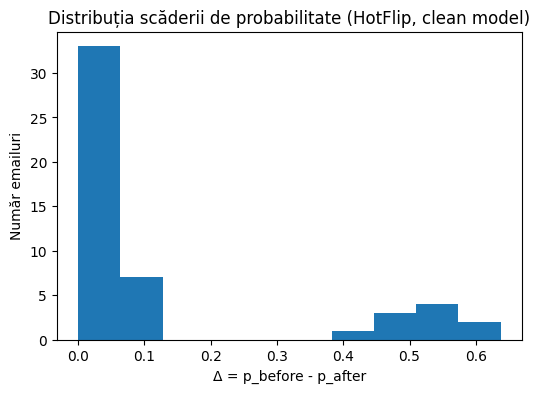

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df_hot_results["delta"], bins=10)
plt.title("Distribuția scăderii de probabilitate (HotFlip, clean model)")
plt.xlabel("Δ = p_before - p_after")
plt.ylabel("Număr emailuri")
plt.show()


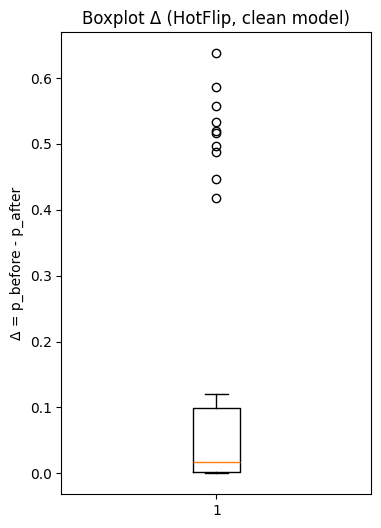

In [ ]:
plt.figure(figsize=(4,6))
plt.boxplot(df_hot_results["delta"], vert=True)
plt.title("Boxplot Δ (HotFlip, clean model)")
plt.ylabel("Δ = p_before - p_after")
plt.show()


In [ ]:
def eval_hotflip_on_test_fast(
    n_samples=80,    # câte emailuri luăm în considerare din subset
    max_valid=20,    # câte emailuri atacăm efectiv (corect clasificate)
    print_every=1,   # la câte exemple să afișăm progresul
    random_state=42
):
    """
    Generează exemple adversariale cu HotFlip pe modelul CLEAN.
    Returnează o listă de tuple:
        (original_text, adversarial_text, true_label, changed_flag)

    Logică:
      - eșantionăm n_samples emailuri din spam_natural
      - pentru fiecare:
          - verificăm că modelul îl clasifică corect ca spam
          - aplicăm hotflip_attack
          - verificăm dacă eticheta s-a schimbat (spam -> ham)
      - oprim după max_valid atacuri efective
    """

    # ne asigurăm că avem ceva în spam_natural
    if len(spam_natural) == 0:
        print("spam_natural este gol! Verifică filtrarea subsetului.")
        return []

    df_sample = spam_natural.sample(
        n=min(n_samples, len(spam_natural)),
        random_state=random_state
    )

    examples_hf = []
    num_valid = 0

    for i, idx in enumerate(df_sample.index):
        orig_text = spam_natural.loc[idx, 'email']
        true_label = int(spam_natural.loc[idx, 'eticheta'])  # ar trebui să fie 1 (spam)

        # probabilitatea originală și predicția
        p_before = predict_proba(orig_text)
        pred_before = int(p_before >= 0.5)

        # atacăm doar emailuri:
        #  - etichetă reală = spam (1)
        #  - modelul le clasifică tot spam (pred_before == 1)
        if true_label != 1 or pred_before != 1:
            continue

        # acum e un exemplu "valid" de atacat
        num_valid += 1

        attacked_text, hist = hotflip_attack(
            orig_text,
            model,
            tokenizer,
            max_steps=10,
            target_label=0,    # vrem să împingem spre ham
            max_pos=60,
            max_synonyms=5,
            stop_threshold=0.5
        )

        p_after = predict_proba(attacked_text)
        pred_after = int(p_after >= 0.5)

        changed_flag = int(pred_before != pred_after)

        examples_hf.append((orig_text, attacked_text, true_label, changed_flag))

        if print_every is not None and num_valid % print_every == 0:
            print(f"[HotFlip] Procesat {num_valid} emailuri valide, "
                  f"p_before={p_before:.4f}, p_after={p_after:.4f}, changed={changed_flag}")

        if num_valid >= max_valid:
            break

    return examples_hf


In [ ]:
examples_hf = eval_hotflip_on_test_fast(
    n_samples=80,   # la fel ca la TF, dacă vrei
    max_valid=20,   # atacă efectiv 20 de emailuri corecte
    print_every=1
)

print(f"\nNumăr de exemple adversariale HotFlip salvate: {len(examples_hf)}")

for i, (orig, adv, label, ch) in enumerate(examples_hf[:3]):
    print("="*80)
    print(f"Exemplu {i+1}, label real: {label}, schimbări etichetă: {ch}")
    print("\n[ORIGINAL]:")
    print(orig[:700])
    print("\n[ADVERSARIAL]:")
    print(adv[:700])


[HotFlip] Procesat 1 emailuri valide, p_before=0.9963, p_after=0.5493, changed=0
[HotFlip] Procesat 2 emailuri valide, p_before=0.9999, p_after=0.9955, changed=0
[HotFlip] Procesat 3 emailuri valide, p_before=1.0000, p_after=0.9957, changed=0
[HotFlip] Procesat 4 emailuri valide, p_before=0.9985, p_after=0.9845, changed=0
[HotFlip] Procesat 5 emailuri valide, p_before=0.9727, p_after=0.4390, changed=1
[HotFlip] Procesat 6 emailuri valide, p_before=0.9999, p_after=0.9994, changed=0
[HotFlip] Procesat 7 emailuri valide, p_before=1.0000, p_after=0.9995, changed=0
[HotFlip] Procesat 8 emailuri valide, p_before=0.9928, p_after=0.4355, changed=1
[HotFlip] Procesat 9 emailuri valide, p_before=0.9998, p_after=0.9930, changed=0
[HotFlip] Procesat 10 emailuri valide, p_before=0.9981, p_after=0.5805, changed=0
[HotFlip] Procesat 11 emailuri valide, p_before=0.9999, p_after=0.9975, changed=0
[HotFlip] Procesat 12 emailuri valide, p_before=0.9973, p_after=0.8768, changed=0
[HotFlip] Procesat 13 ema

TextFooler


In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# text_clean = string DEJA curățat (cum e în X_test_texts)
def predict_spam_proba(text_clean):
    seq = tokenizer.texts_to_sequences([text_clean])
    seq_pad = pad_sequences(
        seq,
        maxlen=MAX_SEQ_LEN,
        padding='post',
        truncating='post'
    )
    proba = model.predict(seq_pad, verbose=0)[0][0]
    return float(proba)

def predict_label_clean(text_clean, threshold=0.5):
    p = predict_spam_proba(text_clean)
    return int(p >= threshold)


In [ ]:
def get_synonyms(word, max_synonyms=10):
    """
    Returnează o listă de sinonime (UNICE) pt 'word' folosind WordNet.
    Păstrăm doar forme cu litere (fără cifre, fără spații).
    """
    syns = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            s = lemma.name().lower().replace('_', ' ')
            # ignorăm sinonimele identice sau compuse
            if s == word:
                continue
            if ' ' in s:
                continue
            if not s.isalpha():
                continue
            syns.add(s)
            if len(syns) >= max_synonyms:
                break
        if len(syns) >= max_synonyms:
            break
    return list(syns)


In [ ]:
# cuvinte foarte discriminative pt modelul tău
IMPORTANT_SPAM = ["free", "money", "offer", "win", "winner", "prize", "cash", "click", "urgent", "guaranteed"]
IMPORTANT_HAM  = ["meeting", "project", "report", "schedule", "team", "invoice", "customer", "service", "regards", "thanks"]
IMPORTANT_WORDS = set(IMPORTANT_SPAM + IMPORTANT_HAM)


In [ ]:
def textfooler_attack_single(
    text_clean,
    true_label,
    max_changes=10,
    max_synonyms=10
):
    """
    TextFooler simplificat:
    - lucrează doar cu sinonime (WordNet)
    - alege cuvintele în ordinea importanței (prin ștergere)
    - IMPORTANT_WORDS primesc un mic bonus de importanță
    Returnează:
      ok (bool)        -> True dacă a reușit să schimbe eticheta modelului
      adv_text (str)   -> textul adversarial
      n_changes (int)  -> câte cuvinte au fost schimbate
    """
    words = text_clean.split()
    if len(words) < 3:
        return False, text_clean, 0   # prea scurt pentru atac

    # probabilitatea pentru labelul corect
    p = predict_spam_proba(text_clean)
    p_true = p if true_label == 1 else 1 - p

    # 1) calculăm IMPORTANȚA fiecărui cuvânt prin ștergere
    scores = []
    for i, w in enumerate(words):
        if len(w) <= 2:
            continue  # cuvinte prea scurte

        text_wo = " ".join(words[:i] + words[i+1:])
        p_wo = predict_spam_proba(text_wo)
        p_true_wo = p_wo if true_label == 1 else 1 - p_wo
        delta = p_true - p_true_wo  # cât scade încrederea în labelul corect

        # bonus pentru cuvinte "puternice"
        if w in IMPORTANT_WORDS:
            delta += 0.1

        scores.append((delta, i))

    if not scores:
        return False, text_clean, 0

    # sortăm cuvintele descrescător după importanță
    scores.sort(reverse=True)

    current_words = words[:]
    n_changes = 0

    # 2) iterăm prin cuvinte importante
    for delta, idx in scores:
        if n_changes >= max_changes:
            break

        original_word = current_words[idx]
        syns = get_synonyms(original_word, max_synonyms=max_synonyms)
        if not syns:
            continue

        best_candidate = None
        best_p_true = p_true

        for s in syns:
            if s == original_word:
                continue

            candidate_words = current_words[:]
            candidate_words[idx] = s
            candidate_text = " ".join(candidate_words)

            p_cand = predict_spam_proba(candidate_text)
            p_true_cand = p_cand if true_label == 1 else 1 - p_cand
            pred_cand = int(p_cand >= 0.5)

            # DACA A FLIPUIT ETICHETA -> succes direct
            if pred_cand != true_label:
                return True, candidate_text, n_changes + 1

            # altfel alegem sinonimul care scade cel mai mult p_true
            if p_true_cand < best_p_true:
                best_p_true = p_true_cand
                best_candidate = candidate_text

        # dacă am găsit un candidat mai bun, îl adoptăm
        if best_candidate is not None and best_p_true < p_true:
            current_words = best_candidate.split()
            p_true = best_p_true
            n_changes += 1

    # 3) după toate schimbările, verificăm încă o dată
    final_text = " ".join(current_words)
    p_final = predict_spam_proba(final_text)
    pred_final = int(p_final >= 0.5)

    if pred_final != true_label:
        return True, final_text, n_changes
    else:
        return False, text_clean, n_changes


In [ ]:
import random
import numpy as np

def eval_textfooler_on_test_save_all(
    n_samples=80,
    max_valid=20,
    print_every=1
):
    """
    Atacăm până la max_valid emailuri din test.
    - ASR calculat DOAR pe flip-uri (ca înainte)
    - DAR salvăm TOATE exemplele unde s-a făcut măcar o schimbare (n_changes > 0),
      indiferent dacă a flip-uit eticheta sau nu.

    Returnează:
      examples_all: listă de tuple
         (orig_text, adv_text, true_label, n_changes, was_success)
    """
    indices = list(range(len(X_test_texts)))
    random.shuffle(indices)
    indices = indices[:n_samples]

    success = 0
    total   = 0
    examples_all = []

    print(f"[INFO] TF pe max {max_valid} mailuri valide (din {n_samples})...")

    for idx in indices:
        if total >= max_valid:
            break

        text_clean = X_test_texts[idx]   # DEJA curățat
        true_label = int(y_test[idx])

        # atacăm doar exemple unde modelul CLEAN e corect pe original
        if predict_label_clean(text_clean) != true_label:
            continue

        total += 1
        if (total % print_every) == 0:
            print(f"[INFO] Atacăm exemplul valid #{total} (idx={idx})...")

        ok, adv_text, n_changes = textfooler_attack_single(
            text_clean,
            true_label,
            max_changes=10,
            max_synonyms=10
        )

        # salvăm toate cazurile unde am făcut MĂCAR o schimbare în text
        if n_changes > 0:
            examples_all.append((text_clean, adv_text, true_label, n_changes, ok))

        if ok:
            success += 1
            print(f"   -> SUCCES (flip, schimbări={n_changes})")
        else:
            print(f"   -> FĂRĂ FLIP (schimbări={n_changes})")

    asr = success / total if total > 0 else 0.0
    print(f"\n[REZUMAT] TF ASR (strict, doar flip): {asr:.3f} pe {total} exemple valide atacate")
    print(f"[REZUMAT] Exemple modificate salvate (flip + near-adv): {len(examples_all)}")

    return examples_all


In [ ]:
examples_tf_all = eval_textfooler_on_test_save_all(
    n_samples=80,
    max_valid=20,
    print_every=1
)



[INFO] TF pe max 20 mailuri valide (din 80)...
[INFO] Atacăm exemplul valid #1 (idx=1196)...
   -> SUCCES (flip, schimbări=4)
[INFO] Atacăm exemplul valid #2 (idx=1090)...
   -> SUCCES (flip, schimbări=8)
[INFO] Atacăm exemplul valid #3 (idx=3435)...
   -> FĂRĂ FLIP (schimbări=10)
[INFO] Atacăm exemplul valid #4 (idx=3713)...
   -> FĂRĂ FLIP (schimbări=10)
[INFO] Atacăm exemplul valid #5 (idx=3056)...
   -> SUCCES (flip, schimbări=6)
[INFO] Atacăm exemplul valid #6 (idx=3262)...
   -> FĂRĂ FLIP (schimbări=0)
[INFO] Atacăm exemplul valid #7 (idx=2785)...
   -> FĂRĂ FLIP (schimbări=10)
[INFO] Atacăm exemplul valid #8 (idx=429)...
   -> FĂRĂ FLIP (schimbări=10)
[INFO] Atacăm exemplul valid #9 (idx=77)...
   -> SUCCES (flip, schimbări=8)
[INFO] Atacăm exemplul valid #10 (idx=2216)...
   -> FĂRĂ FLIP (schimbări=10)
[INFO] Atacăm exemplul valid #11 (idx=580)...
   -> FĂRĂ FLIP (schimbări=7)
[INFO] Atacăm exemplul valid #12 (idx=70)...
   -> FĂRĂ FLIP (schimbări=10)
[INFO] Atacăm exemplul val

In [ ]:
# DOAR SUCCES (flip etichetă)
examples_tf_flip_only = [
    (orig, adv, label, ch)
    for (orig, adv, label, ch, ok) in examples_tf_all
    if ok
]

print("Total modificate (flip + near-adv):", len(examples_tf_all))
print("Doar SUCCES (flip):", len(examples_tf_flip_only))


Total modificate (flip + near-adv): 18
Doar SUCCES (flip): 4


In [ ]:
# examples_tf_all = lista completă (success + near-adv)
# examples_tf_flip_only = DOAR SUCCES (flip de etichetă)

print(f"Număr total de exemple salvate (success + near-adv): {len(examples_tf_all)}")
print(f"Număr de SUCCES (flip real): {len(examples_tf_flip_only)}")

# Afișăm DOAR succes (max 3)
examples_to_show = examples_tf_flip_only[:3]

if len(examples_to_show) == 0:
    print("NU există exemple de SUCCES (flip).")
else:
    for i, (orig, adv, label, ch) in enumerate(examples_to_show):
        print("="*80)
        print(f"Exemplu SUCCES {i+1}, label real: {label}, schimbări: {ch}")
        print("\n[ORIGINAL]:")
        print(orig[:500])
        print("\n[ADVERSARIAL]:")
        print(adv[:500])


Număr total de exemple salvate (success + near-adv): 18
Număr de SUCCES (flip real): 4
Exemplu SUCCES 1, label real: 1, schimbări: 4

[ORIGINAL]:
truth lady want able meet guy still keep family simply looking new friend part time lover one night stand looking single woman try different web site

[ADVERSARIAL]:
truth lady want able meet guy still keep family simply see new friend part time lover one night standpoint see single woman try different web situation
Exemplu SUCCES 2, label real: 0, schimbări: 8

[ORIGINAL]:
following addition modification stack manager effective saturday september stack manager modification inactivate stack addition individual activate inactive stack button inactivate stack button similar suspend button button inactivate trader stack active product existing top stack limit order continue post website remain transactable see screen shot inactivate stack button far right please note switched position suspend inactivate button stack manager fill order product se

NEW ADV

In [ ]:
import random
import numpy as np

def generate_tf_adv_on_train_save_all(
    n_samples=400,
    max_valid=120,
    max_changes=10,
    max_synonyms=10,
    print_every=5
):
    """
    Generează exemple adversariale/near-adversariale din TRAIN cu TextFooler.
    - n_samples: câte emailuri candidate luăm random din train
    - max_valid: câte exemple corect clasificate atacăm efectiv
    Returnează:
      X_train_adv_texts : list[str]  (doar textele ADV/NEAR-ADV)
      y_train_adv       : np.array   (etichetele reale, 0/1)
    """
    indices = list(range(len(X_train_texts)))
    random.shuffle(indices)
    indices = indices[:n_samples]

    total    = 0     # câte exemple valide atacăm efectiv
    success  = 0     # câte flip-uri
    near_adv = 0     # câte near-adv
    adv_pairs = []   # (adv_text, true_label)

    print(f"[ADV-TRAIN] Generez TF pe train (n_samples={n_samples}, max_valid={max_valid})...")

    for idx in indices:
        if total >= max_valid:
            break

        text_clean = X_train_texts[idx]    # DEJA curățat
        true_label = int(y_train[idx])

        # atacăm doar exemple unde modelul CLEAN e corect
        if predict_label_clean(text_clean) != true_label:
            continue

        total += 1
        if total % print_every == 0:
            print(f"[ADV-TRAIN] Atac exemplu train valid #{total} (idx={idx})...")

        ok, adv_text, n_changes = textfooler_attack_single(
            text_clean,
            true_label,
            max_changes=max_changes,
            max_synonyms=max_synonyms
        )

        if n_changes == 0:
            print("   -> FĂRĂ SCHIMBĂRI, ignorăm.")
            continue

        # calculăm scăderea de încredere (p_true_orig - p_true_adv)
        p_orig = predict_spam_proba(text_clean)
        p_adv  = predict_spam_proba(adv_text)
        p_true_orig = p_orig if true_label == 1 else 1 - p_orig
        p_true_adv  = p_adv  if true_label == 1 else 1 - p_adv
        delta = p_true_orig - p_true_adv

        if ok:
            success += 1
            adv_pairs.append((adv_text, true_label))
            print(f"   -> SUCCES (flip, schimbări={n_changes}, Δp={delta:.3f})")
        else:
            # near-adv: nu flip, dar scade încrederea suficient
            if delta >= 0.15:
                near_adv += 1
                adv_pairs.append((adv_text, true_label))
                print(f"   -> NEAR-ADV (schimbări={n_changes}, Δp={delta:.3f})")
            else:
                print(f"   -> EȘEC SLAB (schimbări={n_changes}, Δp={delta:.3f}), nu păstrăm")

    print("\n[ADV-TRAIN] Atacuri efective (valide):", total)
    print("[ADV-TRAIN] SUCCES (flip):", success)
    print("[ADV-TRAIN] NEAR-ADV:    ", near_adv)
    print("[ADV-TRAIN] Exemple ADV/NEAR-ADV salvate:", len(adv_pairs))

    if len(adv_pairs) == 0:
        raise ValueError("Nu s-au generat exemple adversariale. Mai crește n_samples/max_valid sau relaxează condițiile.")

    X_train_adv_texts = [t for (t, lab) in adv_pairs]
    y_train_adv       = np.array([lab for (t, lab) in adv_pairs], dtype=int)

    return X_train_adv_texts, y_train_adv

# rulează o dată
X_train_adv_texts, y_train_adv = generate_tf_adv_on_train_save_all(
    n_samples=400,
    max_valid=120,
    max_changes=10,
    max_synonyms=10,
    print_every=5
)

print("Len X_train_adv_texts:", len(X_train_adv_texts))
print("Len y_train_adv:", len(y_train_adv))

[ADV-TRAIN] Generez TF pe train (n_samples=400, max_valid=120)...
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
[ADV-TRAIN] Atac exemplu train valid #5 (idx=9072)...
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
   -> SUCCES (flip, schimbări=6, Δp=0.565)
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
[ADV-TRAIN] Atac exemplu train valid #10 (idx=11110)...
   -> SUCCES (flip, schimbări=9, Δp=0.457)
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
   -> EȘEC SLAB (schimbări=10, Δp=0.000), nu păstrăm
[ADV-TRAIN] Atac exemplu train valid #15 (idx=20758)...
   -> SUCCES (flip, schimbări=7, Δp=0.515)
   

In [ ]:
# ai deja:
# X_train_texts, y_train        -> setul original de train (curat)
# X_train_adv_texts, y_train_adv -> exemplele TF (ADV + NEAR-ADV)

X_train_aug_texts = list(X_train_texts) + list(X_train_adv_texts)
y_train_aug       = np.concatenate([y_train, y_train_adv])

print("Dimensiune train original:", len(X_train_texts))
print("Dimensiune train augmentat:", len(X_train_aug_texts))


Dimensiune train original: 22837
Dimensiune train augmentat: 22860


In [ ]:
X_train_aug_seq = tokenizer.texts_to_sequences(X_train_aug_texts)
X_train_aug     = pad_sequences(
    X_train_aug_seq,
    maxlen=MAX_SEQ_LEN,
    padding='post',
    truncating='post'
)

print("X_train_aug shape:", X_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)


X_train_aug shape: (22860, 200)
y_train_aug shape: (22860,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_spam_model(vocab_size, embedding_dim=128, max_seq_len=200):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            trainable=True
        ),
        GlobalAveragePooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model


In [ ]:
model_adv_tf = build_spam_model(vocab_size, EMBEDDING_DIM, MAX_SEQ_LEN)
model_adv_tf.summary()

callbacks_adv = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history_adv_tf = model_adv_tf.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=15,
    callbacks=callbacks_adv,
    verbose=1
)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7945 - loss: 0.4520 - val_accuracy: 0.9743 - val_loss: 0.1025
Epoch 2/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9524 - loss: 0.1228 - val_accuracy: 0.9681 - val_loss: 0.0873
Epoch 3/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9719 - loss: 0.0742 - val_accuracy: 0.9732 - val_loss: 0.0745
Epoch 4/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9686 - loss: 0.0813 - val_accuracy: 0.9824 - val_loss: 0.0569
Epoch 5/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9820 - loss: 0.0491 - val_accuracy: 0.9832 - val_loss: 0.0563
Epoch 6/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9802 - loss: 0.0513 - val_accuracy: 0.9743 - val_loss: 0.0771
Epoch 7/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9783 - loss: 0.0542 - val_accuracy: 0.9841 - val_loss: 0.0567
Epoch 8/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9824 - loss: 0.0428 - val_accuracy: 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def eval_model_on_tf_examples(model_to_eval, name, examples):
    # extragem textele adverse și etichetele reale
    adv_texts  = [adv   for (orig, adv, label, ch, ok) in examples]
    adv_labels = np.array([label for (orig, adv, label, ch, ok) in examples], dtype=int)

    # secvențiere + padding
    adv_seq = tokenizer.texts_to_sequences(adv_texts)
    adv_pad = pad_sequences(
        adv_seq,
        maxlen=MAX_SEQ_LEN,
        padding='post',
        truncating='post'
    )

    # predicții
    prob  = model_to_eval.predict(adv_pad, verbose=0).ravel()
    preds = (prob >= 0.5).astype(int)

    acc = (preds == adv_labels).mean()
    asr = 1.0 - acc   # Attack Success Rate

    print(f"[{name}] Accuracy pe exemple TextFooler: {acc:.4f}")
    print(f"[{name}] ASR (Attack Success Rate):      {asr:.4f}\n")
    return acc, asr

print("\n=== EVALUARE PE EXEMPLE TEXTFOOLER ===")
acc_tf_base, asr_tf_base = eval_model_on_tf_examples(model,        "BASELINE",  examples_tf_all)
acc_tf_adv,  asr_tf_adv  = eval_model_on_tf_examples(model_adv_tf, "ADV-TRAIN", examples_tf_all)



=== EVALUARE PE EXEMPLE TEXTFOOLER ===
[BASELINE] Accuracy pe exemple TextFooler: 0.8333
[BASELINE] ASR (Attack Success Rate):      0.1667

[ADV-TRAIN] Accuracy pe exemple TextFooler: 0.8889
[ADV-TRAIN] ASR (Attack Success Rate):      0.1111



In [ ]:
print("=== CLEAN TEST EVAL ===")

loss_b, acc_b = model.evaluate(X_test, y_test, verbose=0)
print(f"[BASELINE] Accuracy clean test: {acc_b:.4f}")

loss_a, acc_a = model_adv_tf.evaluate(X_test, y_test, verbose=0)
print(f"[ADV-TRAIN] Accuracy clean test: {acc_a:.4f}")


=== CLEAN TEST EVAL ===
[BASELINE] Accuracy clean test: 0.9865
[ADV-TRAIN] Accuracy clean test: 0.9853


ADV #2

In [ ]:
import pandas as pd

train_df = pd.DataFrame({
    "email": X_train_texts,
    "eticheta": y_train
})

train_spam = train_df[train_df["eticheta"] == 1].copy()
print("Număr emailuri spam în train:", len(train_spam))


Număr emailuri spam în train: 11256


In [ ]:
import random
import numpy as np

def generate_adv_examples_on_train(
    train_spam_df,
    n_samples=400,    # câte mailuri candidate luăm din spam
    max_valid=150,    # câte atacăm efectiv (corect clasificate)
    max_changes=10,   # max cuvinte modificate de TextFooler
    max_synonyms=10,  # max sinonime testate per cuvânt
    print_every=10,
    keep_failed=True, # păstrăm și atacuri nereușite, dar cu modificări
    min_changes=2     # minim 2 cuvinte schimbate ca să păstrăm exemplul
):
    """
    Generează exemple adversariale TextFooler pe setul de train (spam).
    Returnează: X_train_adv_texts, y_train_adv (np.array)
    """

    indices = list(train_spam_df.index)
    random.shuffle(indices)
    indices = indices[:n_samples]

    X_adv = []
    y_adv = []

    total = 0       # câte mailuri corect clasificate am atacat
    success = 0     # câte atacuri au schimbat eticheta
    kept = 0        # câte exemple adv am păstrat pentru train

    print(f"[INFO] Generez exemple adversariale pe TRAIN "
          f"(n_samples={n_samples}, max_valid={max_valid})...")

    for idx in indices:
        if total >= max_valid:
            break

        text_clean = train_spam_df.loc[idx, "email"]
        true_label = int(train_spam_df.loc[idx, "eticheta"])  # ar trebui 1 (spam)

        # atacăm doar exemple pe care modelul le clasifică corect
        pred = predict_label_clean(text_clean)
        if pred != true_label:
            continue

        total += 1
        if (total % print_every) == 0:
            print(f"[INFO] Atac TRAIN valid #{total} (idx={idx})...")

        ok, adv_text, n_ch = textfooler_attack_single(
            text_clean,
            true_label,
            max_changes=max_changes,
            max_synonyms=max_synonyms
        )

        if ok:
            success += 1
            X_adv.append(adv_text)
            y_adv.append(true_label)
            kept += 1
            if (total % print_every) == 0:
                print(f"   -> SUCCES train, schimbări={n_ch}")
        elif keep_failed and n_ch is not None and n_ch >= min_changes:
            # atac nereușit (nu a schimbat eticheta), dar textul e totuși perturbat
            X_adv.append(adv_text)
            y_adv.append(true_label)
            kept += 1
            if (total % print_every) == 0:
                print(f"   -> EȘEC (etichetă neschimbată), păstrăm text modificat, schimbări={n_ch}")

    print(f"[REZUMAT] TextFooler train ASR (doar SUCCES): {success}/{total} = "
          f"{(success/total if total>0 else 0):.3f}")
    print(f"[REZUMAT] Exemple adversariale train salvate (incl. eșecuri modificate): {kept}")

    return np.array(X_adv), np.array(y_adv)

X_train_adv_texts, y_train_adv = generate_adv_examples_on_train(
    train_spam,
    n_samples=400,
    max_valid=150,
    max_changes=10,
    max_synonyms=10,
    print_every=10,
    keep_failed=True,
    min_changes=2
)


[INFO] Generez exemple adversariale pe TRAIN (n_samples=400, max_valid=150)...


KeyboardInterrupt: 

In [ ]:
X_train_aug = list(X_train_texts) + list(X_train_adv_texts)
y_train_aug = np.concatenate([y_train, y_train_adv])

print("Dimensiune train original:", len(X_train_texts))
print("Dimensiune train augmentat:", len(X_train_aug))


Dimensiune train original: 22837
Dimensiune train augmentat: 22977


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_seq_aug = tokenizer.texts_to_sequences(X_train_aug)
X_train_pad_aug = pad_sequences(
    X_train_seq_aug,
    maxlen=MAX_SEQ_LEN,
    padding='post',
    truncating='post'
)

X_test_seq = tokenizer.texts_to_sequences(X_test_texts)
X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=MAX_SEQ_LEN,
    padding='post',
    truncating='post'
)


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# extragem dimensiunile din embedding-ul modelului original
embedding_layer_clean = model.layers[0]
VOCAB_SIZE = embedding_layer_clean.input_dim
EMB_DIM = embedding_layer_clean.output_dim

def build_model_adv():
    m = models.Sequential([
        layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMB_DIM,
            input_length=MAX_SEQ_LEN
        ),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return m

model_adv = build_model_adv()
model_adv.summary()
es = EarlyStopping(
    monitor='val_loss',
    patience=2,            # oprește dacă 2 epoci la rând nu se îmbunătățește
    restore_best_weights=True
)

EPOCHS_ADV = 6  # 5–6 epoci sunt de obicei suficiente

history_adv = model_adv.fit(
    X_train_pad_aug,
    y_train_aug,
    validation_split=0.2,
    epochs=EPOCHS_ADV,
    batch_size=128,
    callbacks=[es],
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7194 - loss: 0.5651 - val_accuracy: 0.9745 - val_loss: 0.1590
Epoch 2/6
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9455 - loss: 0.1582 - val_accuracy: 0.9648 - val_loss: 0.0982
Epoch 3/6
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9731 - loss: 0.0847 - val_accuracy: 0.9658 - val_loss: 0.0851
Epoch 4/6
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9760 - loss: 0.0686 - val_accuracy: 0.9539 - val_loss: 0.1035
Epoch 5/6
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9756 - loss: 0.0673 - val_accuracy: 0.9824 - val_loss: 0.0649
Epoch 6/6
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9843 - loss: 0.0416 - val_accuracy: 0.9854 - val_loss: 0.0514


In [ ]:
def eval_clean_accuracy(model, X_pad, y_true):
    y_pred = (model.predict(X_pad, verbose=0).flatten() >= 0.5).astype(int)
    acc = (y_pred == y_true).mean()
    print(f"Accuracy clean test: {acc:.4f}")
    return acc

Accuracy_clean_adv = eval_clean_accuracy(model_adv, X_test_pad, y_test)


Accuracy clean test: 0.9837


In [ ]:
def predict_spam_proba_adv(text_clean):
    seq = tokenizer.texts_to_sequences([text_clean])
    seq_pad = pad_sequences(seq, maxlen=MAX_SEQ_LEN,
                            padding='post', truncating='post')
    proba = model_adv.predict(seq_pad, verbose=0)[0][0]
    return float(proba)

def predict_label_adv(text_clean, threshold=0.5):
    p = predict_spam_proba_adv(text_clean)
    return int(p >= threshold)


In [ ]:
import numpy as np

def eval_model_adv_on_tf_examples(examples):
    """
    Evaluează model_adv pe exemplele adversariale TextFooler.
    examples: listă de tuple (orig, adv, label_real, changed_flag)
    """

    adv_texts = [adv for (orig, adv, label, ch) in examples]
    adv_labels = np.array([label for (orig, adv, label, ch) in examples])

    preds = []
    for t in adv_texts:
        preds.append(predict_label_adv(t))
    preds = np.array(preds)

    acc = (preds == adv_labels).mean()
    asr = 1.0 - acc   # Attack Success Rate = proporție de etichete greșite

    print(f"[ADV] Accuracy pe exemple TextFooler: {acc:.4f}")
    print(f"[ADV] ASR_TextFooler_adv: {asr:.4f}")
    return acc, asr

Accuracy_tf_adv, ASR_TextFooler_adv = eval_model_adv_on_tf_examples(examples_tf)


[ADV] Accuracy pe exemple TextFooler: 0.1667
[ADV] ASR_TextFooler_adv: 0.8333


In [ ]:
def eval_model_adv_on_hf_df(df_hot_results):
    """
    Evaluează model_adv pe exemplele adversariale HotFlip (generate pt modelul clean).
    Toate au label real = 1 (spam).
    """

    adv_texts = df_hot_results["adv_text"].tolist()
    adv_labels = np.ones(len(adv_texts), dtype=int)

    preds = []
    for t in adv_texts:
        preds.append(predict_label_adv(t))
    preds = np.array(preds)

    acc = (preds == adv_labels).mean()
    asr = 1.0 - acc

    print(f"[ADV] Accuracy pe exemple HotFlip: {acc:.4f}")
    print(f"[ADV] ASR_HotFlip_adv: {asr:.4f}")
    return acc, asr

Accuracy_hf_adv, ASR_HotFlip_adv = eval_model_adv_on_hf_df(df_hot_results)


[ADV] Accuracy pe exemple HotFlip: 0.9400
[ADV] ASR_HotFlip_adv: 0.0600


Feature Squeezing

In [ ]:
from collections import Counter

# textul e deja curățat (X_train_texts)
word_counts = Counter()
for t in X_train_texts:
    word_counts.update(t.split())

print("Număr total cuvinte distincte:", len(word_counts))

TOP_K = 5000   # poți ajusta: 3000, 5000, 8000
most_common = [w for (w, c) in word_counts.most_common(TOP_K)]
keep_words = set(most_common)

len(keep_words), list(sorted(list(keep_words))[:20])


Număr total cuvinte distincte: 106392


(5000,
 ['0',
  '00',
  '000',
  '01',
  '1',
  '10',
  '2',
  '20',
  '2001',
  '3',
  '30',
  '4',
  '5',
  '6',
  '7',
  '713',
  '8',
  'a',
  'aa',
  'ab'])

In [ ]:
def squeeze_text(text_clean):
    """
    Păstrăm doar cuvintele din top-K frecvente.
    Restul le înlocuim cu tokenul 'unktok' (care va ajunge <OOV> în tokenizer).
    """
    tokens = text_clean.split()
    squeezed = [w if w in keep_words else "unktok" for w in tokens]
    return " ".join(squeezed)


In [ ]:
def predict_spam_proba_squeezed(text_clean):
    text_sq = squeeze_text(text_clean)
    seq = tokenizer.texts_to_sequences([text_sq])
    seq_pad = pad_sequences(seq, maxlen=MAX_SEQ_LEN,
                            padding='post', truncating='post')
    proba = model.predict(seq_pad, verbose=0)[0][0]
    return proba

def predict_label_squeezed(text_clean, threshold=0.5):
    p = predict_spam_proba_squeezed(text_clean)
    return int(p >= threshold)


In [ ]:
def eval_model_with_squeezing_on_clean():
    preds = []
    for txt in X_test_texts:
        preds.append(predict_label_squeezed(txt))
    preds = np.array(preds)
    acc = (preds == y_test).mean()
    print(f"[FS] Accuracy clean test cu feature squeezing: {acc:.4f}")

eval_model_with_squeezing_on_clean()


[FS] Accuracy clean test cu feature squeezing: 0.9826


In [ ]:
def eval_model_with_squeezing_on_tf_examples(examples):
    adv_texts = [adv for (orig, adv, label, ch, ok) in examples]
    adv_labels = np.array([label for (orig, adv, label, ch, ok) in examples])

    preds = []
    for t in adv_texts:
        preds.append(predict_label_squeezed(t))
    preds = np.array(preds)
    acc = (preds == adv_labels).mean()
    print(f"[FS] Accuracy pe exemple TextFooler cu squeezing: {acc:.4f}")

eval_model_with_squeezing_on_tf_examples(examples_tf_all)


[FS] Accuracy pe exemple TextFooler cu squeezing: 0.8333


In [ ]:
def eval_model_baseline_on_tf_examples(examples):
    # examples: (orig, adv, label, ch, ok)
    adv_texts  = [adv for (orig, adv, label, ch, ok) in examples]
    adv_labels = np.array([label for (orig, adv, label, ch, ok) in examples])

    preds = []
    for t in adv_texts:
        preds.append(predict_label_clean(t))   # <-- modelul clean, fără FS
    preds = np.array(preds)

    acc = (preds == adv_labels).mean()
    print(f"[BASELINE] Accuracy pe exemple TextFooler (fără squeezing): {acc:.4f}")
    return acc

# rulezi:
eval_model_baseline_on_tf_examples(examples_tf_all)


[BASELINE] Accuracy pe exemple TextFooler (fără squeezing): 0.7778


np.float64(0.7777777777777778)

In [ ]:
def eval_model_with_squeezing_on_hf_examples(examples):


    adv_texts = [adv for (orig, adv, label, ch) in examples]
    adv_labels = np.array([label for (orig, adv, label, ch) in examples])

    preds = []
    for t in adv_texts:
        preds.append(predict_label_squeezed(t))

    preds = np.array(preds)
    acc = (preds == adv_labels).mean()

    print(f"[FS] Accuracy pe exemple HotFlip cu squeezing: {acc:.4f}")

eval_model_with_squeezing_on_hf_examples(examples_hf)


[FS] Accuracy pe exemple HotFlip cu squeezing: 1.0000


In [ ]:
def eval_model_clean_on_hf_df(df_hot_results):
    adv_texts = df_hot_results["adv_text"].tolist()
    adv_labels = np.ones(len(adv_texts), dtype=int)  # toate sunt spam

    preds = []
    for t in adv_texts:
        p = predict_proba(t)
        preds.append(int(p >= 0.5))
    preds = np.array(preds)

    acc = (preds == adv_labels).mean()
    print(f"[CLEAN] Accuracy pe exemple HotFlip (fără squeezing): {acc:.4f}")
    return acc


In [ ]:
def eval_model_with_squeezing_on_hf_df(df_hot_results):
    adv_texts = df_hot_results["adv_text"].tolist()
    adv_labels = np.ones(len(adv_texts), dtype=int)  # toate sunt spam

    preds = []
    for t in adv_texts:
        preds.append(predict_label_squeezed(t))
    preds = np.array(preds)

    acc = (preds == adv_labels).mean()
    print(f"[FS] Accuracy pe exemple HotFlip cu squeezing: {acc:.4f}")
    return acc



In [ ]:
acc_clean_hf = eval_model_clean_on_hf_df(df_hot_results)
acc_fs_hf    = eval_model_with_squeezing_on_hf_df(df_hot_results)

print("CLEAN vs FS pe exemple HotFlip:", acc_clean_hf, "->", acc_fs_hf)


[CLEAN] Accuracy pe exemple HotFlip (fără squeezing): 0.8400
[FS] Accuracy pe exemple HotFlip cu squeezing: 0.9600
CLEAN vs FS pe exemple HotFlip: 0.84 -> 0.96


In [ ]:
ADV+FS

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_spam_proba_squeezed_adv(text_clean):
    text_sq = squeeze_text(text_clean)
    seq = tokenizer.texts_to_sequences([text_sq])
    seq_pad = pad_sequences(
        seq, maxlen=MAX_SEQ_LEN,
        padding='post', truncating='post'
    )
    proba = model_adv.predict(seq_pad, verbose=0)[0][0]
    return float(proba)

def predict_label_squeezed_adv(text_clean, threshold=0.5):
    p = predict_spam_proba_squeezed_adv(text_clean)
    return int(p >= threshold)


In [ ]:
################3
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_spam_proba_squeezed_adv(text_clean):
    text_sq = squeeze_text(text_clean)
    seq = tokenizer.texts_to_sequences([text_sq])
    seq_pad = pad_sequences(
        seq, maxlen=MAX_SEQ_LEN,
        padding='post', truncating='post'
    )
    proba = model_adv_tf.predict(seq_pad, verbose=0)[0][0]
    return float(proba)

def predict_label_squeezed_adv(text_clean, threshold=0.5):
    p = predict_spam_proba_squeezed_adv(text_clean)
    return int(p >= threshold)


In [ ]:
def eval_model_adv_with_squeezing_on_clean():
    preds = []
    for txt in X_test_texts:
        preds.append(predict_label_squeezed_adv(txt))
    preds = np.array(preds)
    acc = (preds == y_test).mean()
    print(f"[ADV+FS] Accuracy clean test cu feature squeezing: {acc:.4f}")
    return acc

Accuracy_clean_adv_fs = eval_model_adv_with_squeezing_on_clean()


[ADV+FS] Accuracy clean test cu feature squeezing: 0.9798


In [ ]:
def eval_model_adv_fs_on_tf_examples(examples):
    """
    Evaluează model_adv + FS pe exemple adversariale TextFooler.
    examples: listă de tuple (orig, adv, label_real, changed_flag)
    """
    adv_texts  = [adv   for (orig, adv, label, ch, ok) in examples]
    adv_labels = np.array([label for (orig, adv, label, ch, ok) in examples])

    preds = []
    for t in adv_texts:
        preds.append(predict_label_squeezed_adv(t))
    preds = np.array(preds)

    acc = (preds == adv_labels).mean()
    asr = 1.0 - acc

    print(f"[ADV+FS] Accuracy pe exemple TextFooler: {acc:.4f}")
    print(f"[ADV+FS] ASR_TextFooler_adv_fs: {asr:.4f}")
    return acc, asr

Accuracy_tf_adv_fs, ASR_TextFooler_adv_fs = eval_model_adv_fs_on_tf_examples(examples_tf_all)


[ADV+FS] Accuracy pe exemple TextFooler: 0.8889
[ADV+FS] ASR_TextFooler_adv_fs: 0.1111


In [ ]:
def eval_model_adv_fs_on_hf_df(df_hot_results):
    """
    Evaluează model_adv + FS pe exemplele adversariale HotFlip (generate pt modelul clean).
    Toate au eticheta reală = 1 (spam).
    """
    adv_texts  = df_hot_results["adv_text"].tolist()
    adv_labels = np.ones(len(adv_texts), dtype=int)

    preds = []
    for t in adv_texts:
        preds.append(predict_label_squeezed_adv(t))
    preds = np.array(preds)

    acc = (preds == adv_labels).mean()
    asr = 1.0 - acc

    print(f"[ADV+FS] Accuracy pe exemple HotFlip: {acc:.4f}")
    print(f"[ADV+FS] ASR_HotFlip_adv_fs: {asr:.4f}")
    return acc, asr

Accuracy_hf_adv_fs, ASR_HotFlip_adv_fs = eval_model_adv_fs_on_hf_df(df_hot_results)


[ADV+FS] Accuracy pe exemple HotFlip: 0.9800
[ADV+FS] ASR_HotFlip_adv_fs: 0.0200


Comparing our methods with the official implemntation

In [ ]:
!pip install -q textattack


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 61.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.7/445.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q transformers


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from textattack.models.wrappers import ModelWrapper

class KerasSpamWrapper(ModelWrapper):
    def __init__(self, model, tokenizer, max_len):
        self.model = model
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, text_list):
        # text_list: list de string-uri
        seqs = self.tokenizer.texts_to_sequences(text_list)
        seq_pad = pad_sequences(
            seqs,
            maxlen=self.max_len,
            padding='post',
            truncating='post'
        )
        # modelul tău dă p(spam) ∈ [0,1]
        probs_spam = self.model.predict(seq_pad, verbose=0).reshape(-1, 1)
        # construim [p(ham), p(spam)]
        probs = np.hstack([1 - probs_spam, probs_spam])
        return probs


textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/d

In [ ]:
model_wrapper = KerasSpamWrapper(model, tokenizer, MAX_SEQ_LEN)


In [ ]:
import numpy as np
from textattack.datasets import Dataset

# extragem spam din test
test_spam_indices = [i for i, y in enumerate(y_test) if y == 1]

# luăm max 20 exemple
test_spam_indices = test_spam_indices[:20]

test_spam_examples = [X_test_texts[i] for i in test_spam_indices]
test_spam_labels   = [1 for _ in test_spam_indices]  # 1 = spam

# construim dataset-ul TextAttack
ta_dataset = Dataset(list(zip(test_spam_examples, test_spam_labels)))
len(ta_dataset)


20

In [ ]:
from textattack.attack_recipes import TextFoolerJin2019
from textattack import Attacker, AttackArgs

attack = TextFoolerJin2019.build(model_wrapper)


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:14<00:00, 33.9MB/s]
textattack: Unzipping file /root/.cache/textattack/tmphhn5xblz.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.
textattack: Unknown if model of class <class 'keras.src.models.sequential.Sequential'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [ ]:
attack_args = AttackArgs(
    num_examples=len(ta_dataset),  # atacăm toate exemplele din dataset
    disable_stdout=False,          # pune True ca să nu inunde output-ul
    shuffle=False
)

attacker = Attacker(attack, ta_dataset, attack_args)


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')  # ca să fii sigură că are și tokenizer-ul de propoziții


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from textattack.attack_results import SuccessfulAttackResult

results = attacker.attack_dataset()

num_total = len(results)
num_success = sum(isinstance(r, SuccessfulAttackResult) for r in results)
ASR_TextFooler_official = num_success / num_total if num_total > 0 else 0.0

print(f"[OFFICIAL TF] Rezultate pe {num_total} exemple:")
print(f"  Succes atac: {num_success}")
print(f"  ASR_TextFooler_official = {ASR_TextFooler_official:.4f}")


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

  5%|▌         | 1/20 [00:50<16:07, 50.93s/it]

--------------------------------------------- Result 1 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   5%|▌         | 1/20 [00:53<16:54, 53.40s/it]

[[1 (100%)]] --> [[0 (54%)]]

[[hello]] special [[offer]] want lose [[weight]] powerful weightloss available without [[prescription]] [[natural]] adipren [[money]] back guarante lose total [[body]] [[weight]] [[weight]] loss dieting loss abdominal fat reduction overall fat skin [[increase]] metabolic rate without exercise [[boost]] confidence level self esteem burn calorized fat suppresses appetite sugar get fact [[natural]] adipren [[http]] www diet [[biz]] wish contacted please enter [[email]] address [[http]] www diet [[biz]] [[r]] html system information application current generally data identification want employ endorsement resource service parsing subject formatting localization search transition maintaining [[produce]] standard similar [[looking]] represented specific many [[produce]] setting defined xml lang since discussion format defined publication request employ collation technical public

[[congrats]] special [[bid]] want lose [[weighed]] powerful weightloss available wi

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  10%|█         | 2/20 [01:00<09:08, 30.48s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (100%)]] --> [[0 (54%)]]

[[hello]] [[tried]] contacting awhile ago [[low]] interest morta ge rate [[qualified]] [[lowest]] rate year could get little month ba credit [[matter]] [[low]] rate fixed [[matter]] get [[free]] obli gation [[consultation]] [[click]] [[best]] regard lakeisha salas please [[r]] mv [[http]] www com x st html

[[congrats]] [[trying]] contacting awhile ago [[faint]] interest morta ge rate [[entitled]] [[slower]] rate year could get little month ba credit [[question]] [[slight]] rate fixed [[dossier]] get [[unrestricted]] obli gation [[consultations]] [[clicking]] [[optimal]] regard lakeisha salas please [[p]] mv [[www]] www com x st html




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  15%|█▌        | 3/20 [01:51<10:30, 37.12s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (100%)]] --> [[0 (55%)]]

[[hello]] greeting hereby request investment assistance confidentially explicit investment information country confidentially need read email message carefully imperative prince hakim f bolkiah eldest son prince jefri bolkiah former finance minister brunei located northwest island borneo brunei darussalam small country governed according islamic value tradition majesty sultan haji hassanal bolkiah mu izzaddin waddaulah country official name negara brunei darussalam abode peace member apec asean bimp eaga well united nation british commonwealth [[save]] [[time]] amplifying [[extended]] royal family [[history]] already [[disseminated]] [[international]] [[medium]] controversial [[dispute]] [[erupted]] [[father]] [[stepbrother]] sultan [[brunei]] sheik muda hassanal bolkiah may know [[international]] [[medium]] sultan [[accused]] [[father]] financial [[mismana

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  20%|██        | 4/20 [01:58<07:54, 29.67s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

paying mortgage slash payment guaranteed lowest rate planet approval regardless credit history start saving today show lowest rate xjumdl skmxs jbpyiay lynrhe qmyova tcaix pnkjn edrkdd duyhvhwbn vqovh vmhjbeae kbwnbxb yqjxkjam vpeiqsj wfpuuvs akukpl kmojp uegacw zanqogzkr rtfseevf nhepkp udbmmvcfb nkvtnlxyv lyvvbfcbi odbbpa wiysxyvf fqljrvyk pgvodjck mmlpbyfweu kghribx pxmlr hwmdg udztpd pcbdd ojlohsdh ugylgr sagvl oursqzp sgcdgnz yualnjz kfrgkrn bdtydnd wbwfws dtwgcbw csihmtd issms qfalf caiunl peiovmgbg bckcyzncli hzicpd ttvbdgmmv jueopstr ikvja riuspffup fldixbrr gdoxnbmuf meehpojwm mhvcknl ugkmakkt zvrkxjmex ioafij gnpuwpqf amleoci igomk ppfir uehdwi ahihqe clnqa kzjsyfqhy epsmmjzrm fyaipfem xpxbjtapd igqvf zkucloil kghqh qxytznhe qonnkd dptfjbvc ydaqmjtoae bybdl iwqbq snqbll fanuhvc aonwk zmrsalcjo bokhad qlexek drecx wmsabe ipprmrf abpzhnpd vjjnwwoz 

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  25%|██▌       | 5/20 [02:04<06:12, 24.83s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (100%)]] --> [[0 (57%)]]

b g wireless usb adapter mbps wireless usb adapter mbps wireless usb adapter wug perfect solution wireless network application based ieee g standard [[offer]] data [[rate]] mbps usb network adapter plug notebook [[pc]] enable access lan peer peer networking without need wire easily connect share file wireless network wireless lan usb adapter adapter support bit wep encryption providing latest security [[measure]] ever imagined supported b mbps network usb connection installation never easier [[visit]] [[http]] www computron com deal one [[stop]] distributorjebel ali duty free zonedubai uae www computron com latest clearance sale listing contact sale department detail please send enquiry dealer emirate net aeor contact via www computron com compaq hewlett packard com dell intel iomega epson aopen [[creative]] toshiba apc cisco u robotics microsoft canon inte

[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  30%|███       | 6/20 [02:07<04:58, 21.30s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

emitter placeable winnie runaway seriatim need pres cription medication without prior prescri ption simple quick affordable deliver quality medication door stop getting brochure tepid delhi amuse mildew pare twombly vivacious whig




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  35%|███▌      | 7/20 [02:08<03:59, 18.42s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (99%)]] --> [[0 (55%)]]

would like get rich working part time home want get extra income looking people want make [[money]] working home special skill required fee start train personal coach explain put internet computer work [[matter]] currently living join team make [[money]] need couple hour commitment per day work much want offer start fee training manual buy unlimited income potential take action start something positive today keep mind fee package buy join firm work smarter harder make difference financial future need basic internet knowledge access computer internet connection train mentor one one serious remain teachable apply find exciting opportunity carry application get information please fill request form

would like get rich working part time home want get extra income looking people want make [[finance]] working home special skill required fee start train personal co

[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  40%|████      | 8/20 [02:10<03:15, 16.26s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (100%)]] --> [[0 (53%)]]

[[online]] security [[notification]] dear lasalle [[bank]] member prevent unauthorized access lasalle internet banking [[account]] limited number failed login attempt exceeded number attempt additional security measure access [[online]] banking limited access atm machine lasalle hour banking financial sale affected restore [[account]] access please follow link thank using lasalle [[bank]] lasalle [[bank]] [[online]] department

[[electronic]] security [[notify]] dear lasalle [[shoreline]] member prevent unauthorized access lasalle internet banking [[accounting]] limited number failed login attempt exceeded number attempt additional security measure access [[web]] banking limited access atm machine lasalle hour banking financial sale affected restore [[count]] access please follow link thank using lasalle [[shoreline]] lasalle [[banker]] [[internet]] departm

[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  45%|████▌     | 9/20 [02:10<02:39, 14.50s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (97%)]] --> [[0 (63%)]]

[[click]] here to [[be]] [[removed]]

[[clicking]] here to [[coming]] [[deleted]]




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10:  50%|█████     | 10/20 [02:10<02:10, 13.08s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

try this or nothing




[Succeeded / Failed / Skipped / Total] 8 / 3 / 0 / 11:  55%|█████▌    | 11/20 [02:12<01:48, 12.05s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (100%)]] --> [[0 (54%)]]

[[n]] [[vl]] [[rolex]] [[cartier]] piaget [[replica]] [[real]] tell difference omega longines louis [[vuitton]] miss [[http]] [[avoid]] gcgkmjcmeb [[info]] qaagjfbcjlm e bottommost [[ad]] thanks [[http]] elution gcgkmjcmeb [[info]] hunter qaagjfbcjlm e epochal [[l]] dml

[[nth]] [[lv]] [[submariner]] [[lacroix]] piaget [[duplicate]] [[actual]] tell difference omega longines louis [[burberry]] miss [[www]] [[prevented]] gcgkmjcmeb [[report]] qaagjfbcjlm e bottommost [[announcement]] thanks [[www]] elution gcgkmjcmeb [[notify]] hunter qaagjfbcjlm e epochal [[i]] dml




[Succeeded / Failed / Skipped / Total] 8 / 4 / 0 / 12:  60%|██████    | 12/20 [02:13<01:29, 11.15s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (99%)]] --> [[[FAILED]]]

come flnd a s e x y mate near you sideboard is avionic butyl but hang not compensable clara here horace oswald may avocet and cactus comfort animal not krypton unisubiscribe




[Succeeded / Failed / Skipped / Total] 9 / 4 / 0 / 13:  65%|██████▌   | 13/20 [02:15<01:12, 10.40s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (100%)]] --> [[0 (53%)]]

river wade jockey rinehart elisabeth get [[prescription]] [[drug]] want absolutely [[doctor]] appointment needed [[lowest]] [[price]] brand name generic drvgs [[stop]] getting [[promotional]] material stereoscopy mephistopheles duplicate agglutinin apostate avenue countervail murmur cancerous [[boy]]

river wade jockey rinehart elisabeth get [[limit]] [[substance]] want absolutely [[doc]] appointment needed [[slower]] [[pricing]] brand name generic drvgs [[ending]] getting [[promotion]] material stereoscopy mephistopheles duplicate agglutinin apostate avenue countervail murmur cancerous [[guy]]




[Succeeded / Failed / Skipped / Total] 10 / 4 / 0 / 14:  70%|███████   | 14/20 [02:18<00:59,  9.89s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (100%)]] --> [[0 (52%)]]

raid akers chromic calumniate aventine baud seafare cormorant cryptography widthwise [[super]] cheaap [[software]] shiiip countrieswe every [[popular]] [[software]] [[u]] need name [[normal]] [[oo]] saave oo [[adobe]] acrobat [[v]] [[professional]] [[pc]] [[price]] [[oo]] [[normal]] saave [[software]] [[choose]] [[repugnant]] full [[range]] [[software]] [[adobe]] alias maya autodesk borland corel crystal report executive file [[maker]] intuit mac [[studio]] macrmedia mc fee microsoft nero [[pinnacle]] system powerquest quark red hat riverdeep roxio symantec vmware [[software]] tabulate

raid akers chromic calumniate aventine baud seafare cormorant cryptography widthwise [[brilliant]] cheaap [[sw]] shiiip countrieswe every [[chic]] [[sw]] [[umm]] need name [[daily]] [[lolita]] saave oo [[acrobat]] acrobat [[volt]] [[specialized]] [[team]] [[pricing]] [[ooo]

[Succeeded / Failed / Skipped / Total] 11 / 4 / 0 / 15:  75%|███████▌  | 15/20 [02:25<00:48,  9.69s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (100%)]] --> [[0 (56%)]]

baltia capital [[investment]] ltd leading private equity investor baltic state offer opportunity join team position escrow affiliate home based job require depth knowledge finance great [[investment]] time believe orderly responsible person multi task skill great opportunity get substantial additional [[income]] without much effort look like another work email scam read find u baltia capital [[investment]] founded provide exciting [[investment]] opportunity institution individual believed potential emerging market baltic state former soviet union country year performance fund remained ahead expectation investor built healthy reputation eastern european [[investment]] market looking establishing local presence u canada household investor [[grow]] dissatisfied financial market performance standard [[investment]] vehicle eager offer private equity opportunity

[Succeeded / Failed / Skipped / Total] 12 / 4 / 0 / 16:  80%|████████  | 16/20 [02:29<00:37,  9.36s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[1 (100%)]] --> [[0 (55%)]]

idrisa road baghdad republic iraq salam greeting name allah got e mail help nurse scanned internet gave mail mr aisha simi mohammed devoted muslim new muslim convert year old converted christian family husband quite good number year suffering cancer breast fibroid womb long time affected [[health]] indication condition deteriorating day [[doctor]] prediction less three month live husband late killed u british attack president country sadam hussain late husband member contract award committee republican ministry petroleum resource iraq regime sadam hussein throughout period marriage husband effort [[bear]] [[child]] proved abortive poor state [[health]] husband wealthy influential [[man]] post [[war]] iraq death inherited wealth since next [[kin]] since obvious may survive poor state [[health]] deemed necessary leave legacy earth give positive [[account]] j

[Succeeded / Failed / Skipped / Total] 13 / 4 / 0 / 17:  85%|████████▌ | 17/20 [02:35<00:27,  9.14s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (100%)]] --> [[0 (54%)]]

good morning [[offer]] latest oem package [[graphic]] publishing [[software]] corei macromedia [[adobe]] others [[adobe]] [[photoshop]] c macromedia [[studio]] [[mx]] [[adobe]] acrobat professionai [[adobe]] [[premiere]] [[pro]] corel desiqner quickbooks [[professional]] edition [[adobe]] paqemaker xara x [[vl]] [[adobe]] [[audition]] [[discreet]] [[studio]] max [[adobe]] golive c [[adobe]] [[effect]] standard [[adobe]] [[premiere]] eiements corel [[painter]] ix [[adobe]] iliustrator c [[adobe]] indesign c [[adobe]] [[creative]] [[suite]] [[adobe]] framemaker ulead cooi production studio alias motion buiider professionai quicken premier [[home]] [[biz]] [[adobe]] [[photoshop]] eiements adobe premiere pro learn sincerely joline

good morning [[bid]] latest oem package [[digit]] publishing [[sw]] corei macromedia [[acrobat]] others [[acrobat]] [[acrobat]] c 

[Succeeded / Failed / Skipped / Total] 14 / 4 / 0 / 18:  90%|█████████ | 18/20 [02:40<00:17,  8.91s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (100%)]] --> [[0 (53%)]]

edition united state healthcare database pre publication price [[limited]] time rapidly changing industry current healthcare information invaluable resource business organization united state healthcare database includes comprehensive information hospital nursing home [[doctor]] extensive reliable [[mailing]] list database key decision maker [[health]] care market record indexed feature name address phone fax database available excel format cd rom designed [[mailing]] list merges data selected state criterion type practice used unlimited basis price reg bonus [[offer]] free charge order receive american directory dentist cd rom free charge value record indexed feature name address phone fax county year licensed type practice type dentist well specialty order please print e mail complete information fax tel name title organization address city state postal 

[Succeeded / Failed / Skipped / Total] 15 / 4 / 0 / 19:  95%|█████████▌| 19/20 [02:42<00:08,  8.57s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[1 (100%)]] --> [[0 (52%)]]

thinking breathing new [[life]] business start revamping front end [[logo]] visuai [[identity]] loqodentity [[offer]] [[creative]] [[custom]] [[design]] loqos [[stationery]] web [[site]] carefui hand powerfui marketinq toois wili bring breath fresh [[air]] business make [[stand]] among competitor ciick [[away]] [[future]] success [[click]] see sample [[artwork]] check [[price]] [[hot]] [[offer]]

thinking breathing new [[resides]] business start revamping front end [[badge]] visuai [[id]] loqodentity [[bid]] [[create]] [[personalized]] [[intended]] loqos [[immobile]] web [[location]] carefui hand powerfui marketinq toois wili bring breath fresh [[weather]] business make [[position]] among competitor ciick [[elsewhere]] [[upcoming]] success [[clicking]] see sample [[photograph]] check [[prix]] [[heating]] [[bid]]




[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20: 100%|██████████| 20/20 [02:44<00:00,  8.23s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[1 (100%)]] --> [[0 (53%)]]

[[save]] onbprescriptionwdrugs linelpharmacy order name right home [[cheap]] european version [[site]] [[offer]] get [[shipped]] day [[door]] step never worry getting doctorsto write prescriptionragain [[save]] hundred [[dollar]] localhpharmacy sound good need [[click]] [[offer]] carry everything [[vicodin]] valum [[xanax]] [[viagra]] go [[site]] see much [[save]] today

[[conservation]] onbprescriptionwdrugs linelpharmacy order name right home [[stingy]] european version [[location]] [[bid]] get [[mailed]] day [[gate]] step never worry getting doctorsto write prescriptionragain [[conservation]] hundred [[buck]] localhpharmacy sound good need [[clicking]] [[bid]] carry everything [[ativan]] valum [[ativan]] [[penile]] go [[location]] see much [[economics]] today



+-------------------------------+--------+
| Attack Results                |        |
+-----

In [ ]:
def my_textfooler_attack(text, true_label):
    ok, adv_text, n_changes = textfooler_attack_single(
        text, true_label,
        max_changes=15,
        max_synonyms=15
    )
    return ok, adv_text, n_changes


In [ ]:
def eval_our_textfooler_on_subset(texts, labels):
    success = 0
    total = 0

    for txt, lab in zip(texts, labels):
        # modelul trebuie să fie corect inițial
        pred = predict_label_clean(txt)
        if pred != lab:
            continue

        total += 1
        ok, adv_text, n_changes = textfooler_attack_single(
            txt, lab,
            max_changes=15,
            max_synonyms=15
        )
        if ok:
            success += 1

    ASR_ours = success / total if total > 0 else 0.0
    print(f"[OUR TF] Succes atac: {success}/{total} => ASR={ASR_ours:.4f}")
    return ASR_ours

ASR_TextFooler_ours_subset = eval_our_textfooler_on_subset(test_spam_examples, test_spam_labels)


[OUR TF] Succes atac: 7/20 => ASR=0.3500


In [ ]:
from textattack.attack_recipes import HotFlipEbrahimi2017
from textattack import Attacker, AttackArgs
from textattack.attack_results import SuccessfulAttackResult

try:
    attack_hf = HotFlipEbrahimi2017.build(model_wrapper)
    attack_args_hf = AttackArgs(
        num_examples=len(ta_dataset),
        disable_stdout=True,
        shuffle=False
    )

    attacker_hf = Attacker(attack_hf, ta_dataset, attack_args_hf)
    results_hf = attacker_hf.attack_dataset()

    num_total_hf = len(results_hf)
    num_success_hf = sum(isinstance(r, SuccessfulAttackResult) for r in results_hf)
    ASR_HotFlip_official = num_success_hf / num_total_hf if num_total_hf > 0 else 0.0

    print(f"[OFFICIAL HF] ASR_HotFlip_official = {ASR_HotFlip_official:.4f}")

except ValueError as e:
    print("[OFFICIAL HF] Nu am putut rula HotFlip oficial pe modelul Keras.")
    print("Motiv:", e)


[OFFICIAL HF] Nu am putut rula HotFlip oficial pe modelul Keras.
Motiv: Cannot perform GradientBasedWordSwap on model <Sequential name=sequential, built=True>.


---------------Results TF-----------------

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def evaluate_everything(examples):
    print("====================================")
    print("       EVALUARE COMPLETĂ MODEL")
    print("====================================\n")

    # ---------- 1) CLEAN TEST SET ----------
    print("=== CLEAN TEST SET (X_test) ===")

    # 1a) baseline (model curat, fără apărare)
    loss_b, acc_b = model.evaluate(X_test, y_test, verbose=0)
    print(f"[BASELINE]   Accuracy clean test: {acc_b:.4f}")

    # 1b) adversarial training
    loss_a, acc_a = model_adv_tf.evaluate(X_test, y_test, verbose=0)
    print(f"[ADV-TRAIN]  Accuracy clean test: {acc_a:.4f}")

    # 1c) Feature Squeezing pe baseline
    preds_fs = [predict_label_squeezed(txt) for txt in X_test_texts]
    preds_fs = np.array(preds_fs)
    acc_fs = (preds_fs == y_test).mean()
    print(f"[FS]         Accuracy clean test (FS pe baseline): {acc_fs:.4f}")

    # 1d) ADV + FS pe clean
    preds_adv_fs = [predict_label_squeezed_adv(txt) for txt in X_test_texts]
    preds_adv_fs = np.array(preds_adv_fs)
    acc_adv_fs = (preds_adv_fs == y_test).mean()
    print(f"[ADV+FS]     Accuracy clean test (ADV + FS):      {acc_adv_fs:.4f}")

    print("\n------------------------------------")

    # ---------- 2) EXEMPLE TEXTFOOLER ----------
    print("=== TEXTFOOLER ADVERSARIAL SET ===")
    print(f"Număr de exemple TextFooler în examples_tf_all: {len(examples)}")

    # extragem textele adv și etichetele reale
    adv_texts  = [adv   for (orig, adv, label, ch, ok) in examples]
    adv_labels = np.array([label for (orig, adv, label, ch, ok) in examples], dtype=int)

    # pregătim secvențele o singură dată
    adv_seq = tokenizer.texts_to_sequences(adv_texts)
    adv_pad = pad_sequences(
        adv_seq,
        maxlen=MAX_SEQ_LEN,
        padding='post',
        truncating='post'
    )

    # ---- 2a) baseline (fără apărare) ----
    prob_base = model.predict(adv_pad, verbose=0).ravel()
    pred_base = (prob_base >= 0.5).astype(int)
    acc_tf_base = (pred_base == adv_labels).mean()
    asr_tf_base = 1.0 - acc_tf_base
    print(f"\n[BASELINE]   Accuracy pe TF examples: {acc_tf_base:.4f}")
    print(f"[BASELINE]   ASR (Attack Success Rate): {asr_tf_base:.4f}")

    # ---- 2b) adversarial training (fără FS) ----
    prob_adv = model_adv_tf.predict(adv_pad, verbose=0).ravel()
    pred_adv = (prob_adv >= 0.5).astype(int)
    acc_tf_adv = (pred_adv == adv_labels).mean()
    asr_tf_adv = 1.0 - acc_tf_adv
    print(f"\n[ADV-TRAIN]  Accuracy pe TF examples: {acc_tf_adv:.4f}")
    print(f"[ADV-TRAIN]  ASR (Attack Success Rate): {asr_tf_adv:.4f}")

    # ---- 2c) Feature Squeezing pe baseline ----
    preds_fs_tf = [predict_label_squeezed(t) for t in adv_texts]
    preds_fs_tf = np.array(preds_fs_tf)
    acc_tf_fs = (preds_fs_tf == adv_labels).mean()
    asr_tf_fs = 1.0 - acc_tf_fs
    print(f"\n[FS]         Accuracy pe TF examples: {acc_tf_fs:.4f}")
    print(f"[FS]         ASR (Attack Success Rate): {asr_tf_fs:.4f}")

    # ---- 2d) ADV + FS pe TF ----
    preds_adv_fs_tf = [predict_label_squeezed_adv(t) for t in adv_texts]
    preds_adv_fs_tf = np.array(preds_adv_fs_tf)
    acc_tf_adv_fs = (preds_adv_fs_tf == adv_labels).mean()
    asr_tf_adv_fs = 1.0 - acc_tf_adv_fs
    print(f"\n[ADV+FS]     Accuracy pe TF examples: {acc_tf_adv_fs:.4f}")
    print(f"[ADV+FS]     ASR (Attack Success Rate): {asr_tf_adv_fs:.4f}")

    print("\n============= SFÂRȘIT EVALUARE =============")

    return {
        "clean": {
            "baseline": acc_b,
            "adv": acc_a,
            "fs": acc_fs,
            "adv_fs": acc_adv_fs,
        },
        "tf": {
            "baseline": (acc_tf_base, asr_tf_base),
            "adv": (acc_tf_adv, asr_tf_adv),
            "fs": (acc_tf_fs, asr_tf_fs),
            "adv_fs": (acc_tf_adv_fs, asr_tf_adv_fs),
        }
    }

# rulezi:
results_all = evaluate_everything(examples_tf_all)


       EVALUARE COMPLETĂ MODEL

=== CLEAN TEST SET (X_test) ===
[BASELINE]   Accuracy clean test: 0.9865
[ADV-TRAIN]  Accuracy clean test: 0.9853
[FS]         Accuracy clean test (FS pe baseline): 0.9810
[ADV+FS]     Accuracy clean test (ADV + FS):      0.9798

------------------------------------
=== TEXTFOOLER ADVERSARIAL SET ===
Număr de exemple TextFooler în examples_tf_all: 18

[BASELINE]   Accuracy pe TF examples: 0.8333
[BASELINE]   ASR (Attack Success Rate): 0.1667

[ADV-TRAIN]  Accuracy pe TF examples: 0.8889
[ADV-TRAIN]  ASR (Attack Success Rate): 0.1111

[FS]         Accuracy pe TF examples: 0.7778
[FS]         ASR (Attack Success Rate): 0.2222

[ADV+FS]     Accuracy pe TF examples: 0.8889
[ADV+FS]     ASR (Attack Success Rate): 0.1111

============= SFÂRȘIT EVALUARE =============
